In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
## !! CHANGE ME !! ##
from suite2p.io import lbm as lbmio
from suite2p.suite3d import utils
from suite2p.suite3d.job import Job
from suite2p.suite3d import ui

os.chdir('/home/ali/packages/s2p-lbm/')
from utils import tiff_utils as tfu
from utils import file_utils as flu

In [3]:
from mkl_fft import fftn, ifftn
import cupy as cp
import cupyx.scipy.fft as cufft
import scipy.fft

In [4]:
# Create the job
job = Job('/mnt/md0/runs','AH007_2022-03-28_2-4-5', create=False, overwrite=False, verbosity = 10)
tifs, si_params, exp_str = flu.find_exp(job.params['subjects_dir'], job.params['subject'],
                                        job.params['date'], job.params['expnum'])

exp_dir = flu.find_expt_file((job.params['subject'], job.params['date'], job.params['expnum'][0]),
                         'root', dirs=[job.params['subjects_dir']])
offset_files = job.get_registered_files('registered_data', 'offset')

   Found and loaded params from /mnt/md0/runs/s3d-AH007_2022-03-28_2-4-5/params.npy
SI ROI pix count in x is 182, which is impossible, setting it to 145


In [6]:
from suite2p.registration import utils as rgu
from suite2p.registration import rigid, register

In [7]:
cz = (0,25)
ct = (0, 50)
cy = (None,None)
cx = (None,None)

In [8]:
offsets = [n.load(f,allow_pickle=True).item() for f in offset_files]
offset = offsets[0]
for k,v in offset.items():
    offset[k] = n.array(n.concatenate([o[k] for o in offsets],axis=1) )
    offset[k] = offset[k][cz[0]:cz[1], ct[0]:ct[1]]
dx = (offset['xms'] - n.floor(offset['xms'].mean(axis=1,keepdims=True)))[cz[0]:cz[1]]
dy = (offset['yms'] - n.floor(offset['yms'].mean(axis=1,keepdims=True)))[cz[0]:cz[1]]

In [9]:
summary = job.load_summary()
all_ops = summary['all_ops']
crosstalk_coeff = summary['crosstalk_coeff']
refs_and_masks = summary['refs_and_masks']
ref_img = summary['ref_img_3d'][cz[0]:cz[1]]
min_pix_vals = summary['min_pix_vals']
mask_mul, mask_offset, ref_2ds = n.stack([r[:3] for r in refs_and_masks],axis=1)[:,cz[0]:cz[1], cy[0]:cy[1], cx[0]:cx[1]]
mask_mul_nr, mask_offset_nr, ref_nr = n.stack([r[3:] for r in refs_and_masks],axis=1)[:,cz[0]:cz[1], cy[0]:cy[1], cx[0]:cx[1]]

In [10]:
mov_raw = lbmio.load_and_stitch_tifs(job.tifs[1:2], planes = n.arange(cz[0],cz[1]))[:,:,cy[0]:cy[1], cx[0]:cx[1]]
mov_raw = mov_raw[:,ct[0]:ct[1]]
mov_pos = mov_raw - min_pix_vals.reshape(len(min_pix_vals), 1, 1, 1)[cz[0]:cz[1],]

Loading /mnt/a2/AH007/2022-03-28/2/AH007_ROI3p33um_NOSCREEN_-400um_00002_00001.tif
Loaded 1 files, total 5.68 GB


In [11]:
lcorr = 50
np = n

In [17]:

%%time
nz, nt, ny, nx = mov_raw.shape
mov_sub = mov_pos.copy().astype(n.float32)
for i in range(nz - 15):
    mov_sub[i + 15] -= crosstalk_coeff * mov_sub[i]

CPU times: user 4.75 s, sys: 3.38 s, total: 8.13 s
Wall time: 8.13 s


In [20]:
%%time
mov_cpu = mov_sub.copy().astype(n.float32)
xmaxs = []; ymaxs = []; cmaxs = []
for zidx in range(cz[1]-cz[0]):
    movx = n.clip(mov_cpu[zidx], all_ops[zidx]['rmin'], all_ops[zidx]['rmax'])
    mov_cpu_mask = (movx.astype(n.complex64)) * mask_mul[zidx,n.newaxis] + mask_offset[zidx,n.newaxis]
    data = rgu.convolve(mov_cpu_mask, ref_2ds[zidx])

    cc = np.real(np.block( [[data[:,  -lcorr:, -lcorr:], data[:,  -lcorr:, :lcorr+1]],
                            [data[:, :lcorr+1, -lcorr:], data[:, :lcorr+1, :lcorr+1]]] ))
    ymax, xmax = np.zeros(data.shape[0], np.int32), np.zeros(data.shape[0], np.int32)
    for t in np.arange(data.shape[0]):
        ymax[t], xmax[t] = np.unravel_index(np.argmax(cc[t], axis=None), (2 * lcorr + 1, 2 * lcorr + 1))
        cmax = cc[np.arange(len(cc)), ymax, xmax]
    ymax, xmax = ymax - lcorr, xmax - lcorr
    ymaxs.append(ymax); xmaxs.append(xmax); cmaxs.append(cmax)
ymaxs = n.array(ymaxs); xmaxs = n.array(xmaxs); cmaxs = n.array(cmaxs)

CPU times: user 6min 28s, sys: 1min 13s, total: 7min 42s
Wall time: 24 s


In [52]:
%%time
mov_reg = n.zeros_like(mov_cpu)
for zidx in range(cz[1] - cz[0]):
    tidx = 0
    for frame, dy, dx in zip(mov_cpu[zidx], ymaxs[zidx], xmaxs[zidx]):
        mov_reg[zidx, tidx] = rigid.shift_frame(frame=frame, dy=dy, dx=dx)
        tidx += 1

CPU times: user 1.07 s, sys: 712 ms, total: 1.78 s
Wall time: 1.78 s


In [53]:
import mkl_fft

In [54]:
# czx = (0,10)

In [55]:
mov_reg_z = mov_reg.mean(axis=(2,))#[czx[0]:czx[1]]
ref_img_z = ref_img.mean(axis=(1,))#[czx[0]:czx[1]]

In [56]:
mov_bin = mov_reg[:,:,:1000,:1000].reshape(nz, nt, 250,4, 250,4).mean(axis=(3,5)).reshape(nz,nt, -1)
ref_img_bin = ref_img[:,:1000,:1000].reshape(nz,250,4,250,4).mean(axis=(2,4)).reshape(nz,-1)

In [57]:
mov_reg_z = mov_bin
ref_img_z = ref_img_bin

In [58]:
%%time
mov_reg_zf = mkl_fft.fft(mov_reg_z,axis=0)
ref_img_zf = mkl_fft.fft(ref_img_z)
ref_img_zf_c = n.conjugate(mkl_fft.fft(ref_img_z))
ref_img_zf_c /= (n.abs(ref_img_zf_c) + 1e-5)

CPU times: user 954 ms, sys: 183 ms, total: 1.14 s
Wall time: 162 ms


In [59]:
max_shift_z = 8

In [60]:
dotnorm = mov_reg_zf / (n.abs(mov_reg_zf) + n.complex64(1e-5)) * ref_img_zf_c[:,n.newaxis]
pcorr = mkl_fft.ifft(dotnorm,axis=0)
pcorr = n.concatenate([pcorr[-max_shift_z:], pcorr[:max_shift_z+1]])

In [61]:
ccorr_f = mov_reg_zf * ref_img_zf[:,n.newaxis]
ccorr = mkl_fft.ifft(ccorr_f, axis=0)
ccorr = n.concatenate([ccorr[-max_shift_z:], ccorr[:max_shift_z+1]])

In [62]:
ccorr_mean = ccorr[:,:].mean(axis=-1).real

Text(0.5, 1.0, 'Mean cross corr across all pixels per frame')

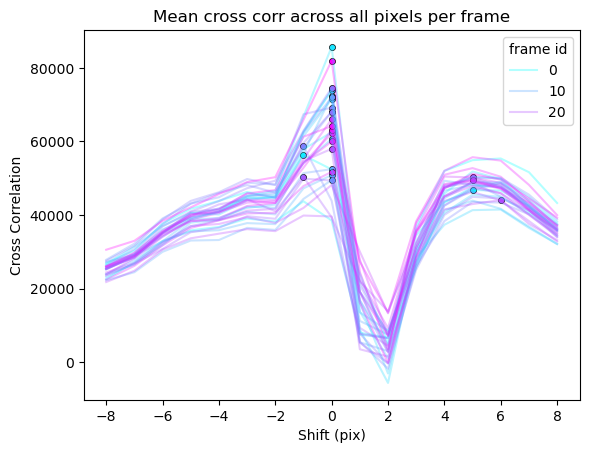

In [64]:
nt_plot = 30
cmap = plt.get_cmap('cool',lut=nt_plot)
lxs = []
xs = n.arange(-max_shift_z, max_shift_z+1)
for i in range(nt_plot):
    lx = plt.plot(xs,
                  ccorr_mean[:,i+1], color=cmap(i), alpha=0.3);
    lxs.append(lx[0])
for i in range(nt_plot):
    plt.scatter([xs[n.argmax(ccorr_mean[:,i+1])]],
                [ccorr_mean[:,i+1].max()], facecolor=cmap(i),
                edgecolor='k', linewidth=0.5, s=19)
plt.legend(lxs[::10], n.arange(0,nt_plot,10), title='frame id')
plt.ylabel("Cross Correlation")
plt.xlabel("Shift (pix)")
plt.title("Mean cross corr across all pixels per frame")

In [65]:
pcorr_mean = pcorr[:,:].mean(axis=-1).real

Text(0.5, 1.0, 'Mean phase corr across all pixels per frame')

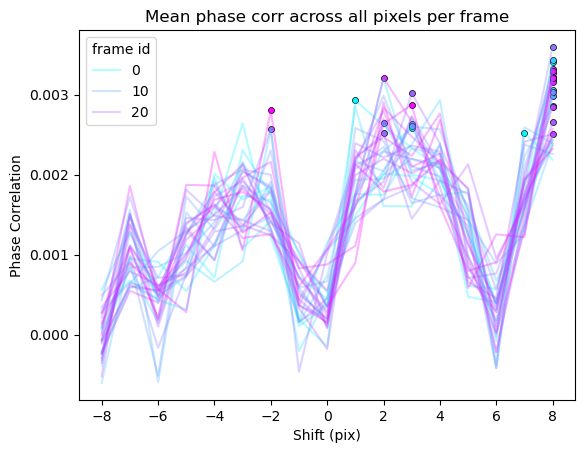

In [67]:
nt_plot = 30
cmap = plt.get_cmap('cool',lut=nt_plot)
lxs = []
xs = n.arange(-max_shift_z, max_shift_z+1)
for i in range(nt_plot):
    lx = plt.plot(xs,
                  pcorr_mean[:,i+1], color=cmap(i), alpha=0.3);
    lxs.append(lx[0])
for i in range(nt_plot):
    plt.scatter([xs[n.argmax(pcorr_mean[:,i+1])]],
                [pcorr_mean[:,i+1].max()], facecolor=cmap(i),
                edgecolor='k', linewidth=0.5, s=19)
plt.legend(lxs[::10], n.arange(0,nt_plot,10), title='frame id')
plt.ylabel("Phase Correlation")
plt.xlabel("Shift (pix)")
plt.title("Mean phase corr across all pixels per frame")

Text(0.5, 1.0, 'Histogram of best zshift for each pixel in one frame')

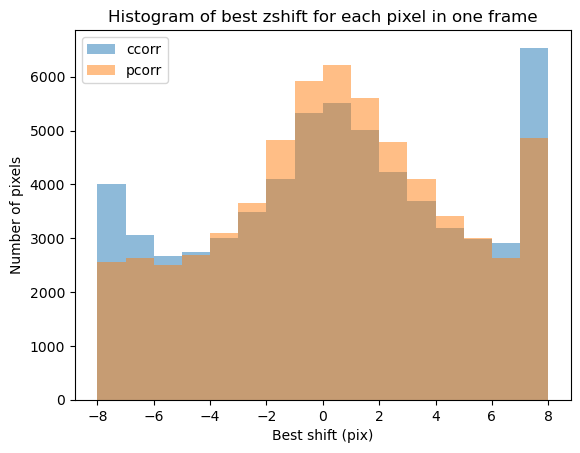

In [68]:
pcorr_f = pcorr[:,10].real
ccorr_f = ccorr[:,10].real

ccorr_f_argmax = ccorr_f.argmax(axis=0)
pcorr_f_argmax = pcorr_f.argmax(axis=0)

plt.hist(ccorr_f_argmax - max_shift_z, bins=16, alpha=0.5, label='ccorr')
plt.hist(pcorr_f_argmax - max_shift_z, bins=16, alpha=0.5, label='pcorr')
plt.legend()
plt.ylabel("Number of pixels")
plt.xlabel("Best shift (pix)")
plt.title("Histogram of best zshift for each pixel in one frame")

In [69]:
zmax_cc = n.argmax(ccorr,axis=0) - max_shift_z

In [70]:
zmax = n.argmax(pcorr.real,axis=0) - max_shift_z

In [71]:
zmax_sq = zmax.reshape(nt, 250, 250)

ValueError: x and y must have same first dimension, but have shapes (100,) and (50,)

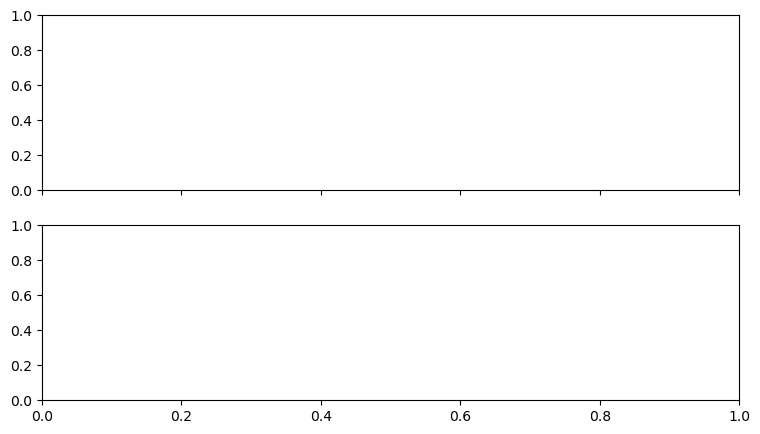

In [74]:
f,axs = plt.subplots(2,1,sharex=True,figsize=(9,5))


zpix_um = 15
for i, file_idx in enumerate(file_idxs):
    axs[0].plot(n.arange(i*100, i*100+100) / 2.8, 
             zmax.mean(axis=-1)[i*100:i*100+100] * zpix_um,
             label = 'F%d,t=%ds' % (file_idx, file_idx * 100 / 2.8))
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Z phasecorr peak (um)")
axs[0].legend()

for i, file_idx in enumerate(file_idxs):
    axs[1].plot(n.arange(i*100, i*100+100) / 2.8, 
             zmax_cc.mean(axis=-1)[i*100:i*100+100] * zpix_um,
             label = 'F%d,t=%ds' % (file_idx, file_idx * 100 / 2.8))
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Z crosscorr peak (um)")
# axs[1].legend()
# plt.xlim(90,110)

In [89]:
ref_img_z_sq = ref_img_z.reshape(nz, 250, 250)
mov_reg_z_sq = mov_reg_z.reshape(nz, nt, 250, 250)

In [164]:
npix_ref = 10
ref_img_tiled = n.tile(ref_img_z_sq[:,n.newaxis],(1,npix_ref,1,1))
mov_and_ref_z_sq = n.concatenate([ref_img_tiled,
                                  mov_reg_z_sq], axis=1)

Text(0, 0.5, 'Z-shift (pix)')

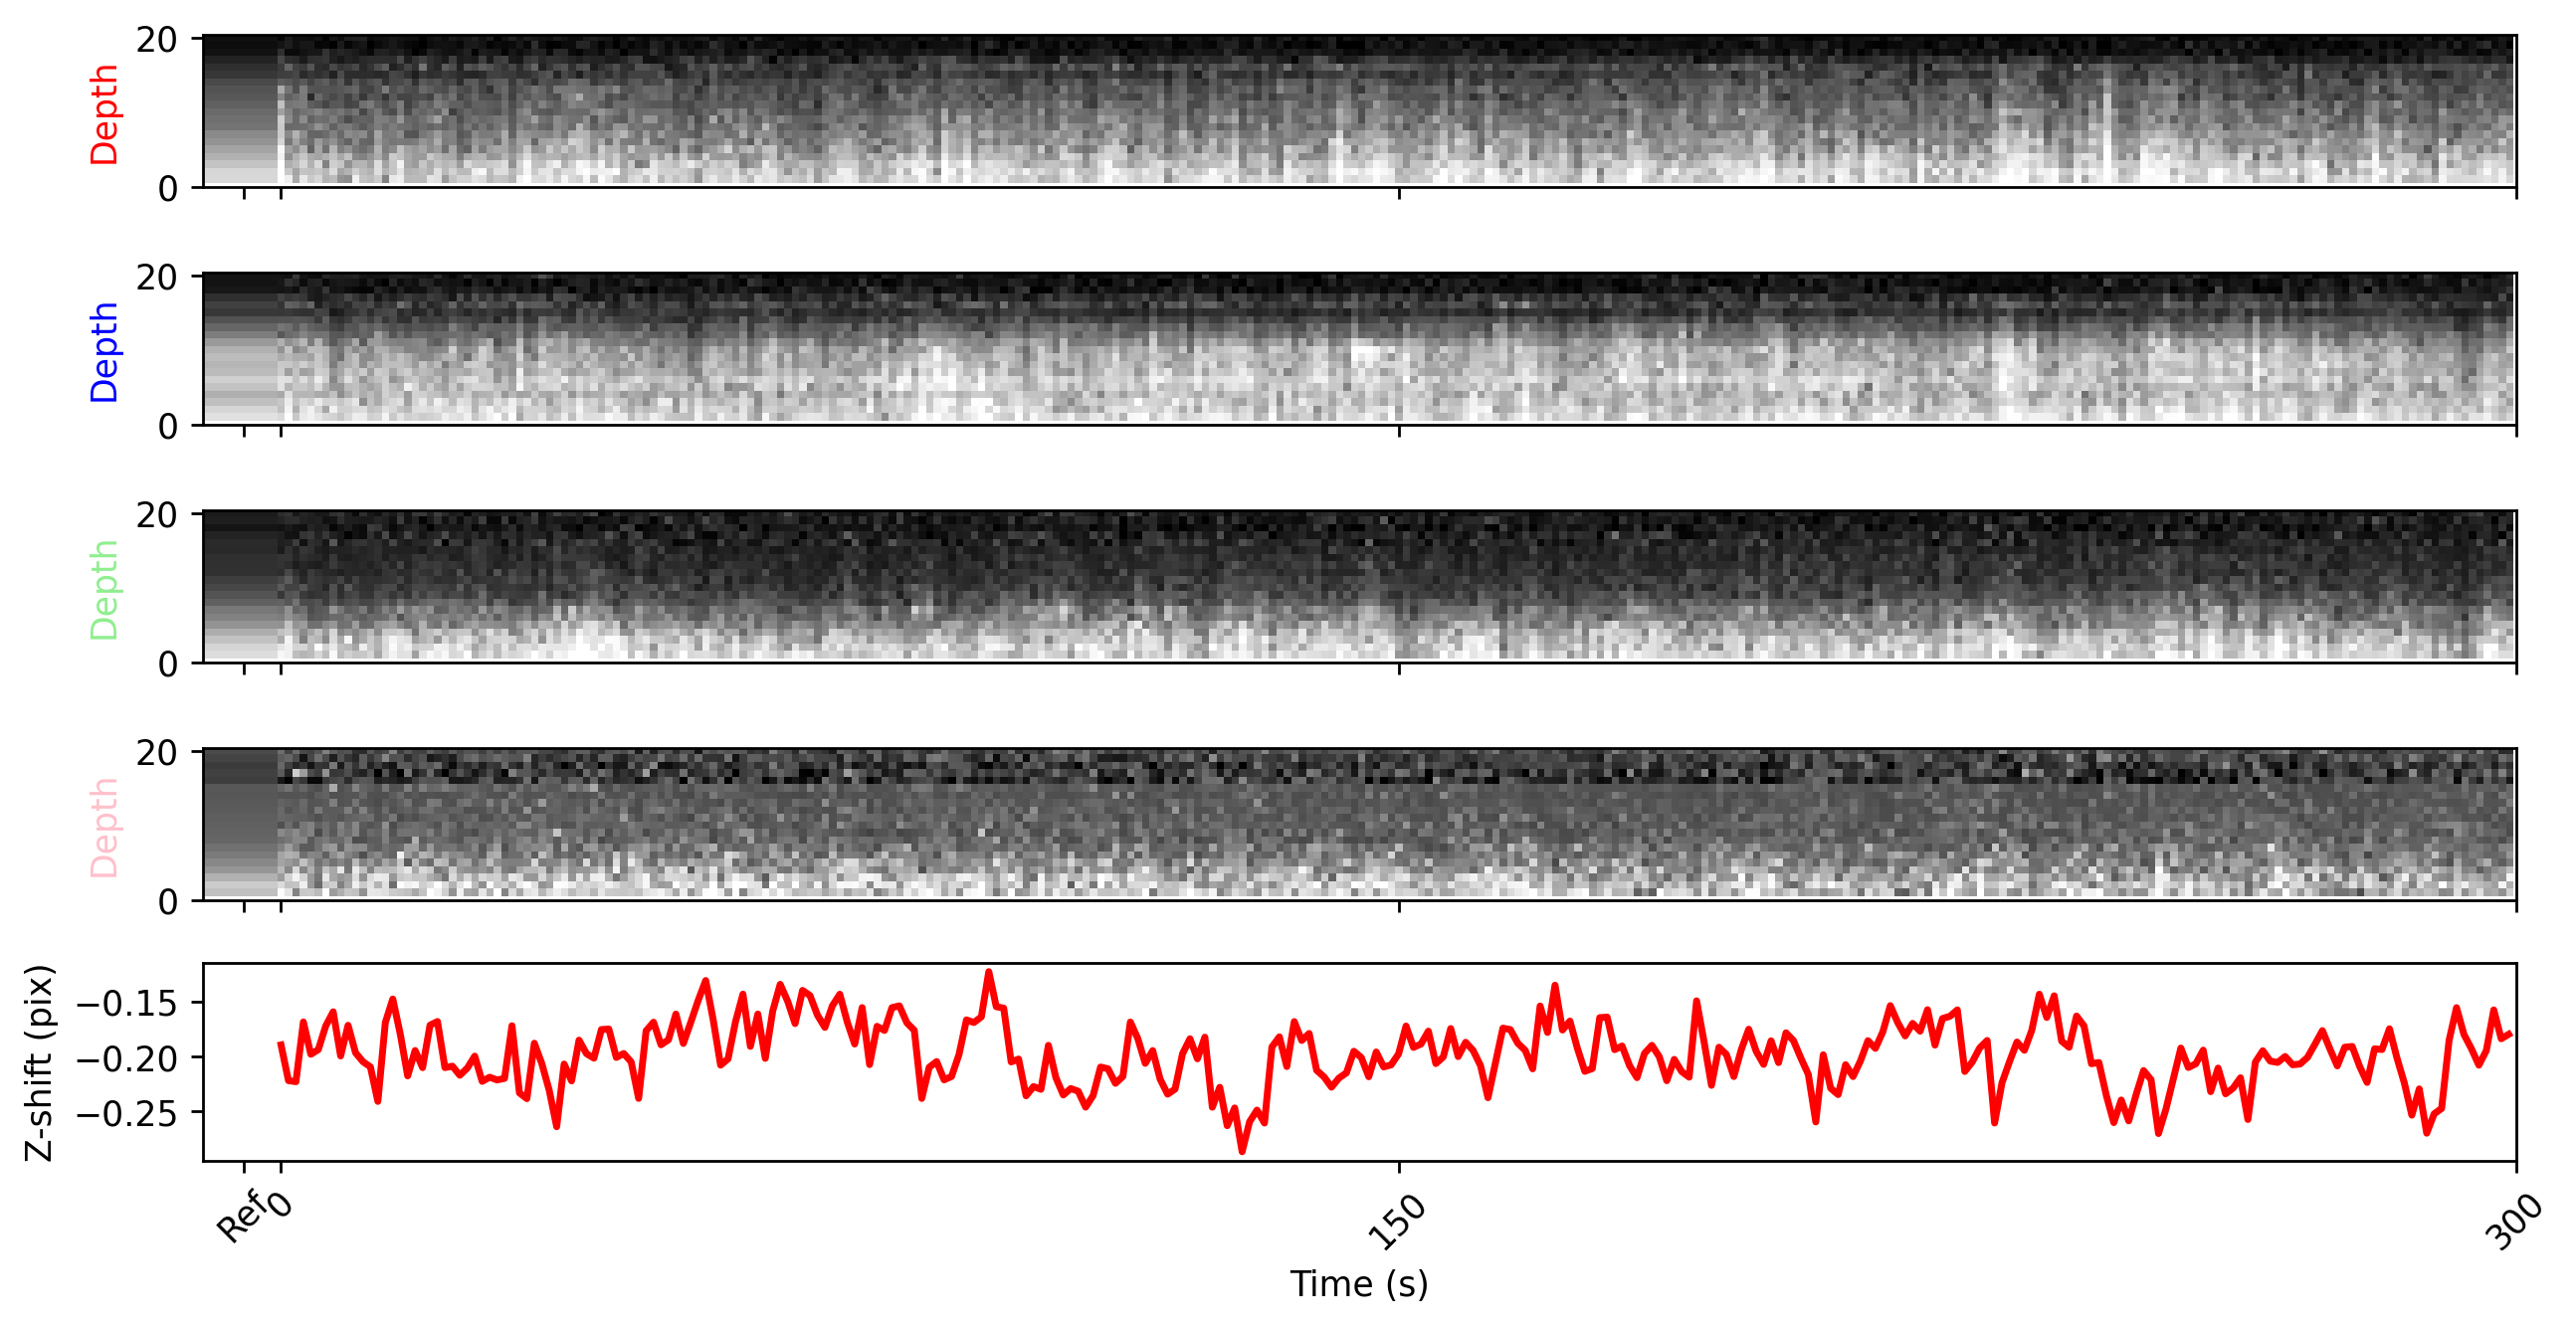

In [192]:
dt = 300
tlim = dt + npix_ref

f,axs = plt.subplots(5,1,figsize=(12,6),sharex=True, dpi=250)


tfu.show_tif(mov_and_ref_z_sq[::-1,:tlim,222,153],ax=axs[0])
axs[0].set_yticks(cz); axs[0].set_yticklabels(cz[::-1])
axs[0].set_ylabel("Depth",color='red')

tfu.show_tif(mov_and_ref_z_sq[::-1,:tlim,180,105],ax=axs[1])
axs[1].set_yticks(cz); axs[1].set_yticklabels(cz[::-1])
axs[1].set_ylabel("Depth",color='blue')

tfu.show_tif(mov_and_ref_z_sq[::-1,:tlim,168,213],ax=axs[2])
axs[2].set_yticks(cz); axs[2].set_yticklabels(cz[::-1])
axs[2].set_ylabel("Depth",color='lightgreen')


tfu.show_tif(mov_and_ref_z_sq[::-1,:tlim,143,185],ax=axs[3])
axs[3].set_yticks(cz); axs[3].set_yticklabels(cz[::-1])
axs[3].set_ylabel("Depth",color='pink')

ax=axs[-1]
ax.plot(n.arange(npix_ref, tlim), 
        zmax.mean(axis=1)[:dt], color='red', linewidth=2)
ax.set_xticks([npix_ref // 2, npix_ref, npix_ref + dt // 2, npix_ref + dt])
ax.set_xticklabels(['Ref', 0, dt // 2, dt], rotation=45)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Z-shift (pix)")

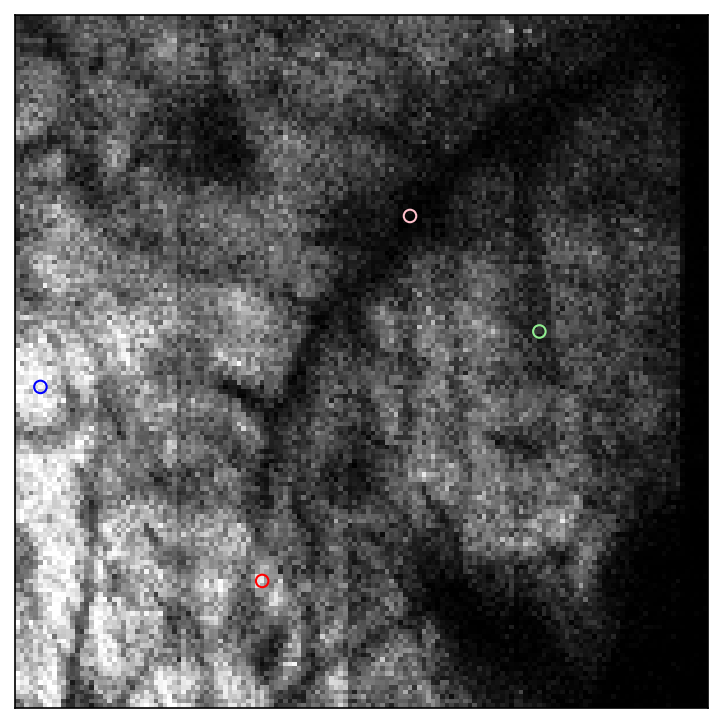

In [190]:
f,ax,__ = tfu.show_tif(mov_reg_z_sq[10, 0,100:250, 100:250])

ax.scatter([53],[122], facecolor='none', edgecolor='red', linewidth=1)
ax.scatter([5],[80], facecolor='none', edgecolor='blue', linewidth=1)
ax.scatter([113],[68], facecolor='none', edgecolor='lightgreen', linewidth=1)
ax.scatter([85],[43], facecolor='none', edgecolor='pink', linewidth=1)

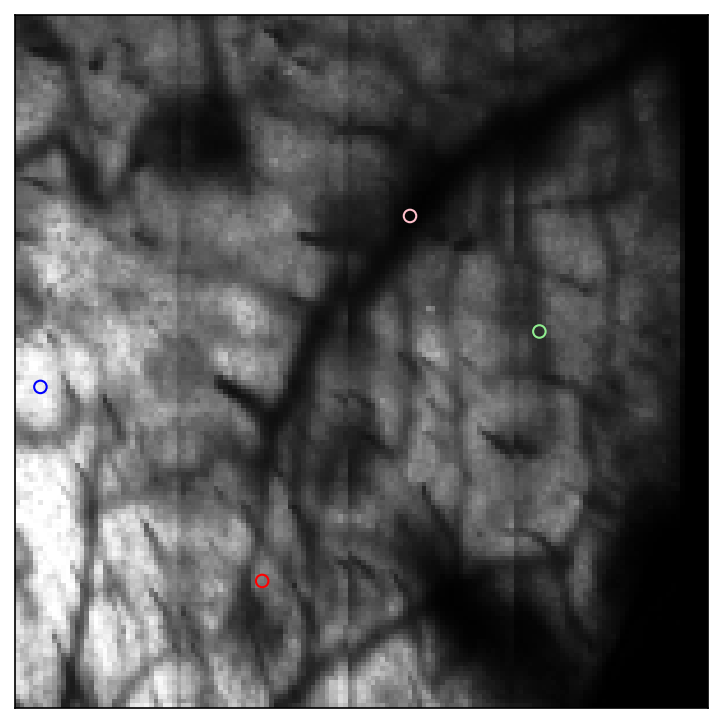

In [240]:
f,ax,__ = tfu.show_tif(ref_img_z_sq[10, 100:400, 100:400])
ax.scatter([53],[122], facecolor='none', edgecolor='red', linewidth=1)
ax.scatter([5],[80], facecolor='none', edgecolor='blue', linewidth=1)
ax.scatter([113],[68], facecolor='none', edgecolor='lightgreen', linewidth=1)
ax.scatter([85],[43], facecolor='none', edgecolor='pink', linewidth=1)